This notebook the first level MRI analyses: setting up and examining a General Linear Model that produces response amplitudes for each stimulus class. For this, the data must be preprocessed. We will use GLMdenoise to do this, which is a MATLAB toolbox, and so the actual analysis will be run outside of this notebook (it takes a while and a lot of resources anyway, so this is for the best).

# Creating the design matrix

The first thing we need to do is create our design matrix. Our design matrix needs to be in the format time by conditions (where time is in TRs), with a 1 for condition onset. This will be exceedingly sparse, since each condition only shows up once per run (when we move this into matlab, we will make it a sparse matrix). We will have one of these design matrices per run.

In [1]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# This file contains the button presses (which also show the TR onsets) 
# and the order the stimuli were presented in (along with their timing)
results = h5py.File('../data/raw_behavioral/2017-Aug-23_Noah_sess1.hdf5')

# This contains the information on each stimulus, allowing us to determine whether
# some stimuli are part of the same class or a separate one.
df = pd.read_csv("../data/stimuli/unshuffled_stim_description.csv", index_col=0)

Backticks from the scanner are recorded as 5s, which we hold onto, allowing us to quickly see how many TRs we recorded in each run (the last run is empty because we quit it as soon as it started):

In [4]:
for run in range(9):
    n_TRs = sum(['5' in i[0] for i in results['run_%02d_button_presses' % run].value])
    print("Run %s: %s TRs" % (run, n_TRs))


Run 0: 256 TRs
Run 1: 256 TRs
Run 2: 256 TRs
Run 3: 256 TRs
Run 4: 256 TRs
Run 5: 256 TRs
Run 6: 256 TRs
Run 7: 256 TRs
Run 8: 0 TRs


We also have the onset times of all of our stimuli, as well as an identifying index we can use to look up its information. We know that we presented stimuli in classes, each of which contains 8 stimuli, but we can reconstruct that information by using the indices to look into the dataframe we loaded in.

Based on how we constructed our stimuli, two stimuli belong to the same class iff they have the same `w_a` and `w_r` (angular and radial frequency) values.

In [3]:
reduced_df = df[['w_r', 'w_a', 'index']].set_index('index')
reduced_df = reduced_df.reindex(results['run_01_shuffled_indices'].value)

As can be seen by examining this reordered dataframe, our classes occur in batches of 8 (note that there are some that have `NaN`s for both values; these are the blank stimuli).

In [7]:
reduced_df

,w_r,w_a
index,,
402,16.0,-28.0
404,16.0,-28.0
400,16.0,-28.0
403,16.0,-28.0
406,16.0,-28.0
401,16.0,-28.0
405,16.0,-28.0
407,16.0,-28.0
121,23.0,0.0


One way to discover this programmatically is to find the smallest amount we have to jump by such that each subsequent entry has a different `w_r` and a different `w_a`.

In [4]:
class_size = 0
break_out = False
while ~break_out:
    class_size += 1
    w_r = reduced_df['w_r'].values.copy()
    w_a = reduced_df['w_a'].values.copy()
    # we replace the NaNs with zeros for this calculation -- we want them be different than all
    # the other classes (and technically, the blank stimuli do have 0s in both w_r and w_a)
    nan_replace = 0
    w_r[np.isnan(w_r)] = nan_replace
    w_a[np.isnan(w_a)] = nan_replace
    tmp = np.abs(w_r[:-class_size:class_size] - w_r[class_size::class_size]) + np.abs(w_a[:-class_size:class_size] - w_a[class_size::class_size])
    class_changes = np.nonzero(tmp)[0]
    indices = np.array(range(len(tmp)))
    if len(class_changes) == len(indices):
        break_out = np.equal(class_changes, indices).all()
print("Each class is of size %s" % class_size)

Each class is of size 8


We want to know what the class index of each stimulus is then, which we can find by dividing the index by the number of stimuli in each class:

In [5]:
reduced_df['class_idx'] = reduced_df.index/class_size

Now we want to figure out what TR each stimulus was presented during. We have the time (in seconds) they appeared on screen recorded, so we want to add that information to our dataframe. In order to do so, we will first subtract off the time of the first TR (so we now have the "time of presentation from first TR") and throw out a bit of extra information. We also recorded when the start screen was turned off (that's the first entry) and there are a final number of blank stimuli, which we'll throw away as well

In [6]:
timing = results['run_01_timing_data'].value
# Because we want to skip the first one and drop the last nblanks * 2 (since for each stimuli
# we have two entries: one for on, one for off). Finally, we only grab every other because we
# only want the on timing
timing = timing[1:-results['run_01_nblanks'].value*2:2]

# Now we get rid of the first TR
initial_TR_time = float(results['run_01_button_presses'].value[0][1])
timing = [float(i[2]) - initial_TR_time for i in timing]

# and add to our dataframe
reduced_df['Onset time (sec)'] = timing

Now we simply look for where there's a class transition, which happens every `class_size` (8) stimuli

In [19]:
design_df = reduced_df[::class_size]

Now we need to convert these to to TR times. First we find the onset times of TRs, in seconds, relative to the first TR. We then create a giant matrix where each row is a different stimulus onset time and then, in each column, subtract a TR onset time (so this matrix will be `num_conditions x num_TRs`). If we then round this difference-in-time matrix and look for the 0s, we've found what TR onset is closest to the onset of the stimuli. Note that this won't make sense for a lot of entries; some of them start almost exactly halfway through a TR. But, because of how we defined our experiment, our class transitions should happen right around a TR onset (if the timings of the scanner and the stimulus computer were perfect, then they would be exactly the same; as it is they probably differ by a few milliseconds) and so this will work

In [20]:
# 5 indicates a backtick from the scanner
TR_times = np.array([float(i[1]) for i in results['run_01_button_presses'].value if '5'==i[0]])
TR_times -= TR_times[0]

In [21]:
stim_times = design_df['Onset time (sec)'].values
stim_times = np.expand_dims(stim_times,1)
stim_times = np.repeat(stim_times,len(TR_times),1)

In [22]:
time_from_TR = np.round(stim_times - TR_times)
design_df['Onset time (TR)'] = np.where(time_from_TR==0)[1]

/home/billbrod/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


And we create our design matrix, iterate through throw our `design_df` and put a one where each class shows up in a TR.

In [11]:
# Our blanks show up as having nan values, and we don't want to model them in our GLM, so we drop them.
design_df = design_df.dropna()
# because the values are 0-indexed
design_matrix = np.zeros((len(TR_times), design_df.class_idx.max()+1))

for i, row in design_df.iterrows():
    row = row.astype(int)
    design_matrix[row['Onset time (TR)'], row['class_idx']] = 1

To make sure things work correctly, we look at our axis sums: each class (axis 1) should show up exactly once and each TR (axis 0) should have 0 or 1 classes in it

In [25]:
print("Each entry represents one of our %d classes:" % design_matrix.shape[1])
print(design_matrix.sum(0))

print("Each entry represents one of our %d TRs:" % design_matrix.shape[0])
print(design_matrix.sum(1))


Each entry represents one of our 52 classes:
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
Each entry represents one of our 256 TRs:
[ 1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.
  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.

And now we can look at our design matrix for this run!

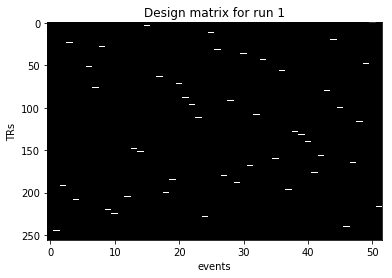

In [26]:
ax = plt.imshow(design_matrix, 'gray', aspect='auto',)
plt.title("Design matrix for run 1")
plt.xlabel("events")
plt.ylabel("TRs")

The function `sfp.first_level_analysis.design_matrix` does the above (without the visualizations and checks) and returns the resulting design matrix. The function `sfp.first_level_analysis.create_all_design_matrices` does this for multiple runs and saves them as `.mat` files so they can be read into matlab.